<a href="https://colab.research.google.com/github/e-c-centric/Group26_Final_Project/blob/main/Group26_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install textstat langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.0 MB/s eta 0:00:00
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=b95d5b5254abb44f610c92b2a42fae4fed705ec492e6495180acbfba1a3fc7cd
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from google.colab import drive
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
import random
import textstat
import langid
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


**Data Collection**

In [ ]:
'''This file was sourced from the Oxford DIctionary. We stripped all the word definitions from the list'''

file_path = '/content/drive/MyDrive/Colab Notebooks/words.txt'

with open(file_path, 'r') as file:
    words = file.read().split()

'''We preprocessed our list of words to remove all words of length less than 3. We also removed
words that contain numbers'''

refined_words = [word for word in words if word.isalpha() and len(word) >= 3]

with open('/content/drive/MyDrive/Colab Notebooks/application_words.txt', 'w') as file:
    file.write('\n'.join(refined_words))

random_sample = random.sample(refined_words, 1000)#creating a subset for training
with open('/content/drive/MyDrive/Colab Notebooks/training_words.txt', 'w') as file:
    file.write('\n'.join(random_sample))

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/training_words.txt'
training_df = pd.read_csv(file_path, sep= " ", names=['word'])
training_df = training_df.dropna()

file_path = '/content/drive/MyDrive/Colab Notebooks/application_words.txt'
application_df = pd.read_csv(file_path, sep= " ", names=['word'])
application_df = application_df.dropna()

In [ ]:
from gensim.models import Word2Vec
#import gensim.downloader as api
#model_name = "word2vec-google-news-300"
#word2vec_model = api.load(model_name)
#training a Word2Vec word embedding model on our application df'''
word2vec_model = Word2Vec(sentences=[application_df['word'].tolist()], vector_size=100, window=5, min_count=1, workers=4)
def word_to_vec(word):
    try:
        return word2vec_model.wv[word]
    except KeyError:
        return None

In [ ]:
training_df.info

<bound method DataFrame.info of                 word
0          fullwords
1          wealthful
2              faery
3               bien
4        disfoliaged
..               ...
995      Platycerium
996  podophthalmitic
997          venules
998            MDACS
999     undescending

[1000 rows x 1 columns]>

In [ ]:
application_df.info

<bound method DataFrame.info of                 word
0                AAA
1               AAAA
2             AAAAAA
3               AAAL
4               AAAS
...              ...
415696  zwitterionic
415697        Zwolle
415698      Zworykin
415699           zZt
415700           ZZZ

[415700 rows x 1 columns]>

**Feature Extraction and Augmentation**

In [ ]:
def extract_features(word):
    try:
        syllables = textstat.syllable_count(word)
        ari = textstat.automated_readability_index(word)
        length = len(word)
        #language, _ = langid.classify(word)

        return {'syllables': syllables, 'ari': ari, 'length': length, 'language': None}
    except Exception as e:
        print(f"Error extracting features for '{word}': {e}")
        return None


feature_columns = ['ari','length']
for column in feature_columns:
    training_df[column] = training_df['word'].apply(lambda word: extract_features(word)[column] if extract_features(word) else None)

# Drop rows with missing features
training_df = training_df.dropna(subset=feature_columns)

In [ ]:
training_df.tail()

,word,ari,length
995,Platycerium,30.9,11
996,podophthalmitic,49.7,15
997,venules,12.0,7
998,MDACS,2.6,5
999,undescending,35.6,12


In [ ]:
'''unique_elements = training_df['language'].unique()

print(unique_elements)'''

"unique_elements = training_df['language'].unique()\n\nprint(unique_elements)"

In [ ]:
'''label_encoder = LabelEncoder()
training_df['language'] = label_encoder.fit_transform(training_df['language'])'''

"label_encoder = LabelEncoder()\ntraining_df['language'] = label_encoder.fit_transform(training_df['language'])"

In [ ]:
training_df['word_vector'] = training_df['word'].apply(word_to_vec)

training_df = training_df.dropna(subset=['word_vector'])

**Scaling**

In [ ]:
scaler = StandardScaler()

X_train_word_vector = np.stack(training_df['word_vector'].to_numpy())
X_train_other_features = scaler.fit_transform(training_df[feature_columns])

X_train = np.concatenate((X_train_word_vector, X_train_other_features), axis=1)

In [ ]:
training_df

,word,ari,length,word_vector
0,fullwords,21.5,9,"[0.0077405954, 0.0029341686, 0.0033583308, -0...."
1,wealthful,21.5,9,"[0.0007027149, -0.002174523, 0.0021456135, 0.0..."
2,faery,2.6,5,"[0.0015684175, -0.005820459, -0.0030434965, 0...."
3,bien,-2.2,4,"[-0.007639743, 0.00909951, -0.00711702, -0.008..."
4,disfoliaged,30.9,11,"[0.006201693, 0.0046572518, -0.0016358948, 0.0..."
...,...,...,...,...
995,Platycerium,30.9,11,"[0.002985536, 0.002697028, -0.009923629, 0.008..."
996,podophthalmitic,49.7,15,"[-0.0016845203, -0.0042065787, -0.0011288703, ..."
997,venules,12.0,7,"[-0.0029379833, 0.0056716693, 0.005209936, -0...."
998,MDACS,2.6,5,"[0.0012034822, -0.007561735, 0.00914108, 0.005..."


In [ ]:
X_train

array([[ 7.74059538e-03,  2.93416856e-03,  3.35833081e-03, ...,
        -4.57348581e-03, -7.18034919e-02, -7.42404331e-02],
       [ 7.02714897e-04, -2.17452296e-03,  2.14561354e-03, ...,
         5.14384033e-03, -7.18034919e-02, -7.42404331e-02],
       [ 1.56841753e-03, -5.82045922e-03, -3.04349652e-03, ...,
         6.32146839e-03, -1.43708115e+00, -1.43645021e+00],
       ...,
       [-2.93798326e-03,  5.67166926e-03,  5.20993583e-03, ...,
        -4.86354716e-03, -7.58054169e-01, -7.55345323e-01],
       [ 1.20348216e-03, -7.56173488e-03,  9.14108008e-03, ...,
        -6.21338980e-03, -1.43708115e+00, -1.43645021e+00],
       [ 1.05104446e-04, -2.19426514e-03,  6.76966552e-03, ...,
        -7.41967559e-03,  9.46736987e-01,  9.47416903e-01]])

**Using the Elbow Method to find the optimal number of clusters**

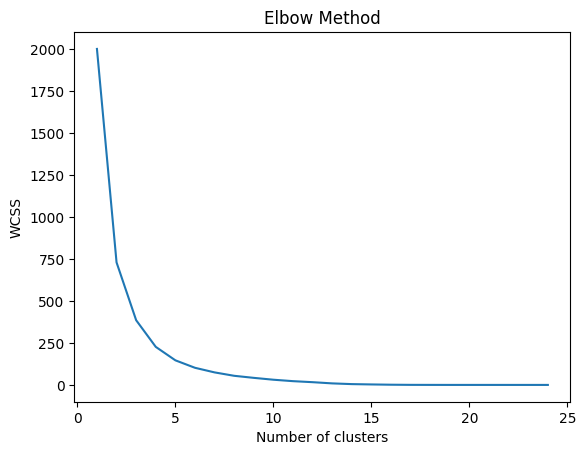

In [ ]:
wcss = []

for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 25), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

optimal_clusters = 16

kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
training_df['cluster'] = kmeans.fit_predict(X_train)

In [ ]:
training_df

,word,ari,length,word_vector,cluster
0,fullwords,21.5,9,"[0.0077405954, 0.0029341686, 0.0033583308, -0....",3
1,wealthful,21.5,9,"[0.0007027149, -0.002174523, 0.0021456135, 0.0...",3
2,faery,2.6,5,"[0.0015684175, -0.005820459, -0.0030434965, 0....",4
3,bien,-2.2,4,"[-0.007639743, 0.00909951, -0.00711702, -0.008...",13
4,disfoliaged,30.9,11,"[0.006201693, 0.0046572518, -0.0016358948, 0.0...",8
...,...,...,...,...,...
995,Platycerium,30.9,11,"[0.002985536, 0.002697028, -0.009923629, 0.008...",8
996,podophthalmitic,49.7,15,"[-0.0016845203, -0.0042065787, -0.0011288703, ...",14
997,venules,12.0,7,"[-0.0029379833, 0.0056716693, 0.005209936, -0....",1
998,MDACS,2.6,5,"[0.0012034822, -0.007561735, 0.00914108, 0.005...",4


In [ ]:
#A Silhouette Score between 0.7 to 1 indicates clusters are well formed and distinct from other clusters
silhouette_avg = silhouette_score(X_train, training_df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.826362907518634


In [ ]:
def predict_cluster(word):
    # Extract features for the word (similar to the preprocessing steps during training)
    word_vector = word_to_vec(word)
    features = extract_features(word)
    ari = features['ari']
    length = features['length']
    #lang = features['language']
    features=[ari,length]
    '''print(f"Word Vector: {word_vector}")
    print(f"Features: {features}")'''

    # Check if any feature is None (indicating an issue with feature extraction)
    if None in features or word_vector is None:
        print(f"Error extracting features for '{word}'. Unable to predict the cluster.")
        return None

    # Concatenate features
    input_features = np.concatenate([word_vector, features])
    input_features = input_features.reshape(1, -1)


    # Predict the cluster
    predicted_cluster = kmeans.predict(input_features)

    return predicted_cluster[0]


word_to_predict = "noise"
predicted_cluster = predict_cluster(word_to_predict)

if predicted_cluster is not None:
    print(f"The predicted cluster for '{word_to_predict}' is: {predicted_cluster}")
else:
    print("Unable to predict the cluster.")


The predicted cluster for 'noise' is: 15


In [ ]:
random_words = application_df['word'].sample(n=4, random_state=42)

print("Random Words:")
print(random_words)

Random Words:
92233     depersonalization
111743              empower
54319         carbosilicate
114641          entreatment
Name: word, dtype: object


In [ ]:
type(random_words)

pandas.core.series.Series

In [ ]:
!pip install gtts pydub

In [ ]:
random_words = random_words.tolist()
random_words

['depersonalization', 'empower', 'carbosilicate', 'entreatment']

In [ ]:
index = random.randint(0,3)
word = random_words[index]
word

'depersonalization'

In [ ]:
from gtts import gTTS
import IPython.display as ipd
import io


print(f"\nWord {index + 1}: {word}")

# Generate the pronunciation using gTTS
tts = gTTS(text=word, lang='en', slow=False)

# Save the audio to a BytesIO object
audio_buffer = io.BytesIO()
tts.write_to_fp(audio_buffer)

# Play the audio in the notebook
ipd.display(ipd.Audio(audio_buffer.getvalue(), autoplay=True))

# Track the index of the pronounced word
print(f"The index of the pronounced word is: {index + 1}")



Word 1: depersonalization


The index of the pronounced word is: 1


In [ ]:
cluster_of_random_word = predict_cluster(word)

In [ ]:
print(f"Cluster of Random Word: {cluster_of_random_word}")

words_in_same_cluster = application_df[application_df['word'].apply(predict_cluster) == cluster_of_random_word]

# Select 4 random words from the same cluster
random_words_from_same_cluster = words_in_same_cluster['word'].sample(n=4, random_state=42)

Cluster of Random Word: 15


In [ ]:
random_words_from_same_cluster = random_words_from_same_cluster.tolist()
index = random.randint(0,3)
word = random_words_from_same_cluster[index]
word

'flittermice'

In [ ]:
tts = gTTS(text=word, lang='en', slow=False)

audio_buffer = io.BytesIO()
tts.write_to_fp(audio_buffer)

ipd.display(ipd.Audio(audio_buffer.getvalue(), autoplay=True))

print(f"The index of the pronounced word is: {index + 1}")


The index of the pronounced word is: 3


In [ ]:
cluster_of_random_word = predict_cluster(word)
cluster_of_random_word

15

In [ ]:
import time
stored_clusters = []

def play_round():
    random_words = application_df['word'].sample(n=4)
    random_words = random_words.tolist()
    index = random.randint(0,3)
    word_to_pronounce = random_words[index]

    print(f"\nListen to the word")
    tts = gTTS(text=word_to_pronounce, lang='en', slow=False)
    tts.save('pronunciation.mp3')
    ipd.display(ipd.Audio('pronunciation.mp3', autoplay=True), metadata=dict(rate=44100))
    time.sleep(2)


    print("\nSelect the correct option by index:")
    for index, word in enumerate(random_words):
        print(f"{index + 1}. {word}")

    user_input = int(input("Enter the index of the correct option: "))

    if user_input == index + 1:
        print("Correct!!")
    elif user_input == index + 1:
        cluster_of_incorrect_word = predict_cluster(word_to_pronounce)
        print(f"Incorrect! Predicted cluster of the incorrectly selected word: {cluster_of_incorrect_word}")
        stored_clusters.append(cluster_of_incorrect_word)


for _ in range(5):
    play_round()


print("\nStored clusters:", stored_clusters)
print("Use these clusters to regulate the randomization in future iterations.")


Listen to the word



Select the correct option by index:
1. preborrowing
2. pollbook
3. solert
4. Crimora
Enter the index of the correct option: 2
Incorrect! Predicted cluster of the incorrectly selected word: 15

Listen to the word



Select the correct option by index:
1. merosystematic
2. Mendham
3. recollectiveness
4. tuliac
Enter the index of the correct option: 3
Incorrect! Predicted cluster of the incorrectly selected word: 15

Listen to the word



Select the correct option by index:
1. osmous
2. Trincomali
3. slabness
4. grangerising
Enter the index of the correct option: 2
Incorrect! Predicted cluster of the incorrectly selected word: 15

Listen to the word



Select the correct option by index:
1. hyperleucocytosis
2. intertwines
3. kopeks
4. thyroidal
Enter the index of the correct option: 0
Incorrect! Predicted cluster of the incorrectly selected word: 15

Listen to the word



Select the correct option by index:
1. Pistia
2. athumia
3. uphelm
4. subsilicate
Enter the index of the correct option: 3
Incorrect! Predicted cluster of the incorrectly selected word: 15

Stored clusters: [15, 15, 15, 15, 15]
Use these clusters to regulate the randomization in future iterations.


In [ ]:
for i in range(5):
    random_words = application_df['word'].sample(n=4)
    random_words = random_words.tolist()
    index = random.randint(0,3)
    word_to_pronounce = random_words[index]
    print(word_to_pronounce)

palaeoclimatological
Bellville
Patricio
haglin
nomothetes


In [ ]:
stored_clusters = []
def play_round():
    random_words = application_df['word'].sample(n=4)
    random_words = random_words.tolist()
    index = random.randint(0, 3)
    word_to_pronounce = random_words[index]

    print(f"\nListen to the word: {word_to_pronounce}")
    tts = gTTS(text=word_to_pronounce, lang='en', slow=False)
    tts.save('pronunciation.mp3')
    ipd.display(ipd.Audio('pronunciation.mp3', autoplay=True), metadata=dict(rate=44100))
    time.sleep(3)

    print("\nSelect the correct option by index:")
    for i, word in enumerate(random_words):
        print(f"{i + 1}. {word}")

    user_input = int(input("Enter the index of the correct option: "))

    print(f"User input: {user_input}")
    print(f"Correct index: {index + 1}")

    if user_input == index + 1:
        print("Correct!!")
    elif user_input == index + 1:
        cluster_of_incorrect_word = predict_cluster(word_to_pronounce)
        print(f"Incorrect! Predicted cluster of the incorrectly selected word: {cluster_of_incorrect_word}")
        stored_clusters.append(cluster_of_incorrect_word)


for _ in range(5):
    play_round()

print("\nStored clusters:", stored_clusters)
print("Use these clusters to regulate the randomization in future iterations.")



Listen to the word: latten



Select the correct option by index:
1. phemic
2. taratantarize
3. latten
4. guideship
Enter the index of the correct option: 3
User input: 3
Correct index: 3
Correct!!

Listen to the word: torcular



Select the correct option by index:
1. torcular
2. trustability
3. gigadoid
4. rheinberry
Enter the index of the correct option: 1
User input: 1
Correct index: 1
Correct!!

Listen to the word: goloka



Select the correct option by index:
1. goloka
2. selfpropelling
3. Hypoxis
4. witneys
Enter the index of the correct option: 1
User input: 1
Correct index: 1
Correct!!

Listen to the word: maunge



Select the correct option by index:
1. arteriotrepsis
2. maunge
3. fillers
4. persists
Enter the index of the correct option: 2
User input: 2
Correct index: 2
Correct!!

Listen to the word: evaporable



Select the correct option by index:
1. lumachel
2. evaporable
3. undecomposable
4. infinitate
Enter the index of the correct option: 2
User input: 2
Correct index: 2
Correct!!

Stored clusters: []
Use these clusters to regulate the randomization in future iterations.


In [ ]:
import joblib
joblib.dump(kmeans, '/content/drive/MyDrive/Colab Notebooks/kmeans_model.pkl')

['/content/drive/MyDrive/Colab Notebooks/kmeans_model.pkl']